# LSTM for Time Series Prediction

`Author: YUAN Yanzhe`
- a demo for LSTM in the application of time series prediction
- a regression task


## LSTM on Passenger Prediction

- 一些细节：
  - squeeze函数
    - torch.unsqueeze(input, dim, out=None)将输入张量维度的指定位置加上1维度
    - torch.squeeze(input, dim=None, out=None)将输入张量维度中的1去除并返回
    - unsqueeze_ 和 unsqueeze 实现一样的功能,区别在于 unsqueeze_ 是 in_place 操作,即 unsqueeze 不会对使用 unsqueeze 的 tensor 进行改变,想要获取 unsqueeze 后的值必须赋予个新值, unsqueeze_ 则会对自己改变。
  - window_len参数实际上是LSTM的隐层time-step数，若把这个看成一个语言模型，这个就是句子的单词数。在这个demo中，用一个长度为4的window，设定用过去四个数据(4\*12)来预测下一个(1\*12)的数据，12是特征。具体每个1\*12输入进一个LSTM cell，输出的hidden的向量维度是num_hidden，在这里是10.
  - reshape(-1, 1).squeeze()不错的转换为1维的方法

In [42]:
import torch 
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [43]:
data = pd.read_csv('/Users/yanzheyuan/coding/dataset/airline-passengers.csv')
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [44]:
data.shape

(144, 2)

In [47]:
# Data Preprocessing
num_feature = 12

sc = MinMaxScaler()  # normalization
data_clean = sc.fit_transform(np.array(data.iloc[:,1:]).astype(np.float32)).reshape(-1,num_feature)
data_clean.shape

(12, 12)

the size of the training set: 8 4
rnn(
  (lstm): LSTM(12, 10, batch_first=True)
  (linear): Linear(in_features=10, out_features=12, bias=True)
)
Epoch: 20, Loss: 0.008889
Epoch: 40, Loss: 0.018671
Epoch: 60, Loss: 0.010075
Epoch: 80, Loss: 0.009168
Epoch: 100, Loss: 0.013527
Epoch: 120, Loss: 0.008549
Epoch: 140, Loss: 0.010815
Epoch: 160, Loss: 0.010588
Epoch: 180, Loss: 0.009585
Epoch: 200, Loss: 0.009492
Epoch: 220, Loss: 0.009434
Epoch: 240, Loss: 0.009302
Epoch: 260, Loss: 0.009122
Epoch: 280, Loss: 0.008897
Epoch: 300, Loss: 0.008567
Epoch: 320, Loss: 0.007732
Epoch: 340, Loss: 0.011217
Epoch: 360, Loss: 0.007702
Epoch: 380, Loss: 0.007514
Epoch: 400, Loss: 0.010635
8


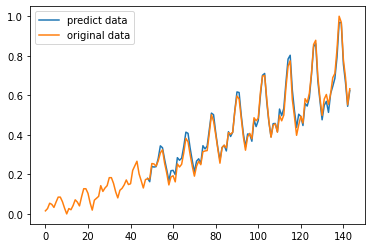

In [69]:
# Obtain Data
# batch_size = 4, every example in a batch is a 12-month passenger-stats
window_len = 4
train_data = []
train_label = []
for i in range(data_clean.shape[0]-window_len):
    train_data.append(data_clean[i:i+window_len,:])
    train_label.append(data_clean[i+window_len,:])

print('the size of the training set:',len(train_data),len(train_data[0]))
#for X,y in zip(train_data,train_label):
#    print(X.shape)  # 4,12
#    print(y.shape)  # 1,12
#    break

# Hyperparameters
num_epochs = 400
learning_rate = 0.01

num_input = 12
num_hidden = 10
num_output = 12
num_layer = 1

# Define Model
class rnn(nn.Module):
    def __init__(self,num_input,num_hidden,num_output,num_layer):
        super(rnn,self).__init__()
        self.lstm = nn.LSTM(input_size=num_input,hidden_size=num_hidden,num_layers=num_layer,batch_first=True)
        self.linear = nn.Linear(num_hidden,num_output)
        
    def forward(self,x):
        _, (h_out, _) = self.lstm(x)  # h_out's shape (batchsize, n_layer*n_direction, hidden_dim), i.e. (1, 1, 10)
        h_out = h_out.view(h_out.shape[0],-1)
        h_out = self.linear(h_out)
        return h_out

net = rnn(num_input,num_hidden,num_output,num_layer)
print(net)

loss_func = nn.MSELoss()
optimizor = torch.optim.Adam(net.parameters(),lr=learning_rate)

# Train Model
for param in net.parameters():
    torch.nn.init.normal_(param,mean=0,std=0.01)

for epoch in range(num_epochs):
    total_loss = 0.0
    for X,y in zip(train_data,train_label):
        X = torch.tensor(X)  # no need for float()
        y = torch.tensor(y)
        X = torch.unsqueeze(X,0)  # add batch_size = 1
        output = net(X)
        loss = loss_func(torch.squeeze(output),y)  # reduce the batch_size dim
        optimizor.zero_grad()
        loss.backward()
        optimizor.step()
        
        total_loss += loss.item()
    
    if (epoch+1) % 20 == 0:
        print('Epoch: %d, Loss: %f' %(epoch+1,total_loss))
        
# Prediction
net.eval()
predict = []
for X in train_data:
    X = torch.tensor(X)
    X = torch.unsqueeze(X,0)
    output = net(X)
    output = torch.squeeze(output)
    predict.append(output.data.numpy())
print(len(predict))

# Visualize Prediction
plt.figure()
predict = np.array(predict)
predict = predict.reshape(-1, 1).squeeze()
x_tick = np.arange(len(predict)) + (window_len*num_feature)
plt.plot(list(x_tick), predict, label='predict data')
 
data_original = data_clean.reshape(-1, 1).squeeze()
plt.plot(range(len(data_original)), data_original, label='original data')
 
plt.legend(loc='best')
plt.show()




(4, 12)


In [1]:
a = [[0]*2 for i in range(10)]

In [2]:
a

[[0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0]]

AttributeError: 'list' object has no attribute 'sum'